# QSARtuna CLI Tutorial

### Create configuration

QSARtuna configuration can be read from a JSON file or created in Python. Here we create it in Python.

In [2]:
import sys
sys.path.append(".")

In [3]:
# Start with the imports.
import sklearn
from optunaz.three_step_opt_build_merge import (
    optimize,
    buildconfig_best,
    build_best,
    build_merged,
)
from optunaz.config import ModelMode, OptimizationDirection
from optunaz.config.optconfig import (
    OptimizationConfig,
    SVR,
    RandomForestRegressor,
    Ridge,
    Lasso,
    PLSRegression,
    KNeighborsRegressor
)
from optunaz.datareader import Dataset
from optunaz.descriptors import ECFP, MACCS_keys, ECFP_counts, PathFP, Avalon, JazzyDescriptors, PhyschemDescriptors

#### FOR REGRESSION：

In [133]:
# Prepare hyperparameter optimization configuration.
config = OptimizationConfig(
    data=Dataset(
        input_column="SMILES",  # Typical names are "SMILES" and "smiles".
        response_column="active",  # Often a specific name (like here), or just "activity".
        training_dataset_file="./trainset.csv",
        test_dataset_file="./testset.csv"  # Hidden during optimization.
    ),
    descriptors=[
        ECFP.new(),
        ECFP_counts.new(),
        MACCS_keys.new(),
        PathFP.new()
    ],
    algorithms=[
        SVR.new(),
        RandomForestRegressor.new(n_estimators={"low": 5, "high": 10}),
        Ridge.new(),
        Lasso.new(),
        PLSRegression.new(),
        KNeighborsRegressor.new()
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.REGRESSION,
        cross_validation=3,
        n_trials=100,  # Total number of trials.
        n_startup_trials=50,  # Number of startup ("random") trials.
        random_seed=42, # Seed for reproducability
        direction=OptimizationDirection.MAXIMIZATION,
    ),
) 

#### FOR CLASSIFICATION：

In [4]:
from optunaz.config.optconfig import ChemPropClassifier, RandomForestClassifier, CalibratedClassifierCVWithVA
from optunaz.descriptors import SmilesBasedDescriptor, SmilesFromFile

config = OptimizationConfig(
    data=Dataset(
        input_column="SMILES",  # Typical names are "SMILES" and "smiles".
        response_column="active",  # Often a specific name (like here), or just "activity".
        training_dataset_file="./trainset.csv",
        test_dataset_file="./testset.csv"  # Hidden during optimization.
    ),
    descriptors=[
        SmilesFromFile.new(),
        ECFP.new(),
        ECFP_counts.new(),
        MACCS_keys.new(),
        PathFP.new(),
        Avalon.new(),
        JazzyDescriptors.new(), 
        PhyschemDescriptors.new()
    ],
    algorithms=[
        ChemPropClassifier.new(epochs=20),
        RandomForestClassifier.new(n_estimators={"low": 100, "high": 200}),
        CalibratedClassifierCVWithVA.new(
            estimator=RandomForestClassifier.new(
                n_estimators=RandomForestClassifier.Parameters.RandomForestClassifierParametersNEstimators(
                    low=100, high=200
                )
            ),
            n_folds=5,
            ensemble="True",
            method="sigmoid", 
        )
    ],
    settings=OptimizationConfig.Settings(
        mode=ModelMode.CLASSIFICATION,
        cross_validation=2,
        n_trials=50, # run only one random forest classifier trial
        n_chemprop_trials=50, # run one enqueued chemprop trial and 1 undirected trial
        split_chemprop=True, # this is set to true by default (shown here for illustration)
        direction=OptimizationDirection.MAXIMIZATION,
    ),
)

### Run optimization

In [108]:
# Setup basic logging.
import logging
from importlib import reload
reload(logging)
logging.basicConfig(level=logging.INFO)
logging.getLogger("train").disabled = True # Prevent ChemProp from logging
import numpy as np
np.seterr(divide="ignore")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import tqdm
from functools import partialmethod, partial
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True) # Prevent tqdm in ChemProp from flooding log

# Avoid decpreciated warnings from packages etc
import warnings
warnings.simplefilter("ignore")
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [ ]:
# Run Optuna Study.
study = optimize(config, study_name="my_study")
# Optuna will log it's progress to sys.stderr
# (usually rendered in red in Jupyter Notebooks).

[I 2024-12-24 15:38:39,642] Trial 97 finished with value: -13.779217497998767 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 29, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 9, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 83 with value: -13.621852629523232.
[I 2024-12-24 15:38:39,709] Trial 98 finished with value: -17.419364451364448 and parameters: {'algorithm_name': 'RandomForestRegressor', 'RandomForestRegressor_algorithm_hash': 'f1ac01e1bba332215ccbd0c29c9ac3c3', 'max_depth__f1ac01e1bba332215ccbd0c29c9ac3c3': 29, 'n_estimators__f1ac01e1bba332215ccbd0c29c9ac3c3': 5, 'max_features__f1ac01e1bba332215ccbd0c29c9ac3c3': <RandomForestMaxFeatures.AUTO: 'auto'>, 'descriptor': '{"name": "MACCS_keys", "parameters": {}}'}. Best is trial 83

### Visualize optimization progress

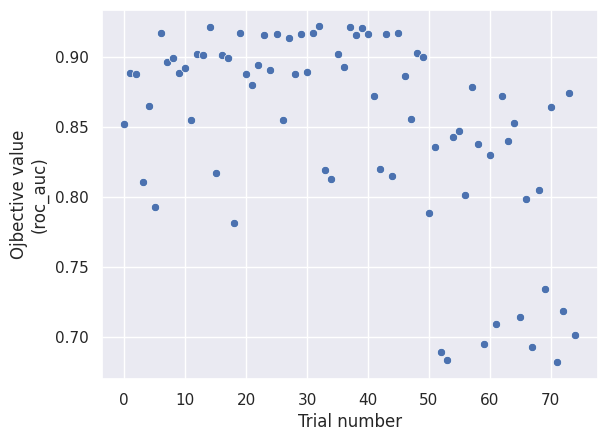

In [110]:
import seaborn as sns
sns.set_theme(style="darkgrid")
default_reg_scoring= config.settings.scoring
ax = sns.scatterplot(data=study.trials_dataframe(), x="number", y="value");
ax.set(xlabel="Trial number", ylabel=f"Ojbective value\n({default_reg_scoring})");

Sometimes it might be interesting to look at individual CV scores instead of aggregated score (mean CV score by default). Here we can plot all 3 cross validation scores (neg_mean_squared_error) for each trial (folds highlighted using different colors).

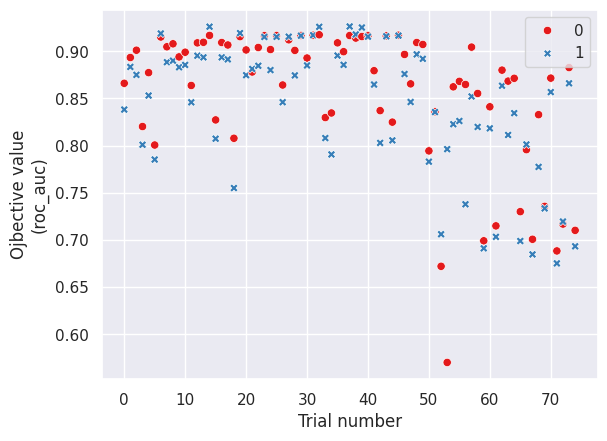

In [111]:
cv_test = study.trials_dataframe()["user_attrs_test_scores"].map(lambda d: d[default_reg_scoring])
x = []
y = []
fold = []
for i, vs in cv_test.items():
    for idx, v in enumerate(vs):
        x.append(i)
        y.append(v)
        fold.append(idx)
ax = sns.scatterplot(x=x, y=y, hue=fold, style=fold, palette='Set1')
ax.set(xlabel="Trial number", ylabel=f"Ojbective value\n({default_reg_scoring})");

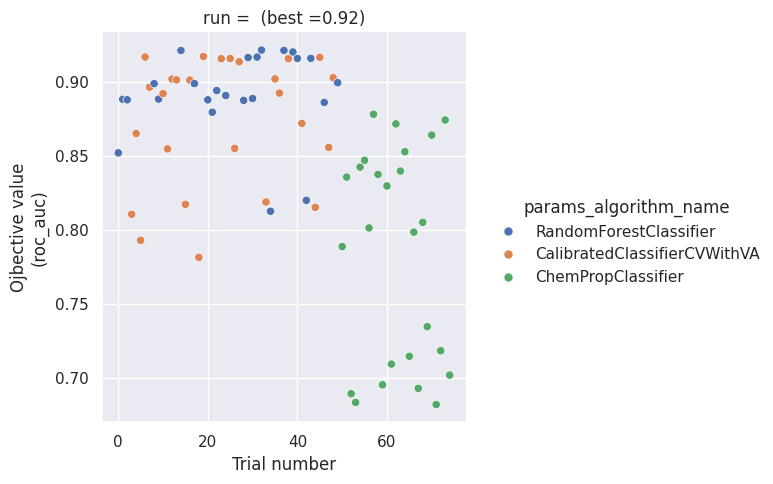

In [164]:
import seaborn as sns

comparison = study.trials_dataframe().assign(run=f' (best ={study.best_value:.2f})')

default_reg_scoring= config.settings.scoring
ax = sns.relplot(data=comparison, x="number", y="value", 
                 col='run',hue='params_algorithm_name', 
                 facet_kws={"sharey":False})
ax.set(xlabel="Trial number",ylabel=f"Ojbective value\n({default_reg_scoring})")
ax.tight_layout()

### Pick the best trial and build a model for it

We pick the best trial, inspect its configuration, build the best model, and save it as a pickled file.

In [ ]:
# Get the best Trial from the Study and make a Build (Training) configuration for it.
buildconfig = buildconfig_best(study)

Optional: write out JSON of the best configuration.

In [113]:
import apischema
buildconfig_as_dict = apischema.serialize(buildconfig)

import json
print(json.dumps(buildconfig_as_dict, indent=2))

{
  "data": {
    "training_dataset_file": "./trainset.csv",
    "input_column": "SMILES",
    "response_column": "active",
    "response_type": "classification",
    "deduplication_strategy": {
      "name": "KeepMedian"
    },
    "split_strategy": {
      "name": "NoSplitting"
    },
    "test_dataset_file": "./testset.csv",
    "save_intermediate_files": false,
    "log_transform": false,
    "log_transform_base": null,
    "log_transform_negative": null,
    "log_transform_unit_conversion": null,
    "probabilistic_threshold_representation": false,
    "probabilistic_threshold_representation_threshold": null,
    "probabilistic_threshold_representation_std": null
  },
  "metadata": {
    "name": "",
    "cross_validation": 2,
    "shuffle": false,
    "best_trial": 32,
    "best_value": 0.9216449955568833,
    "n_trials": 50,
    "visualization": null
  },
  "descriptor": {
    "name": "ECFP_counts",
    "parameters": {
      "radius": 3,
      "useFeatures": true,
      "nBits": 

Build (re-Train) and save the best model. This time training uses all training data, without splitting it into cross-validation folds.

In [ ]:
best_build = build_best(buildconfig, "./best.pkl")

Now we can explore how good the best model performs on the test (holdout) set.

In [8]:
import pickle
with open("./best.pkl", "rb") as f:
    model_best = pickle.load(f)
model_best.predict_from_smiles(["NC1=NC=CC=C1C2=NC3=CC=C(C4=C(F)C(N5CC6(CN(C(C)=O)C6)C5)=CC=C4)N=C3N2C7=CC=C(C8(CCC8)N)C=C7", "CC(=O)Nc1ccc(O)cc1"])

array([0.28909778, 0.17693303])

In [9]:
import pandas as pd

df_best = pd.read_csv(config.data.test_dataset_file)  # Load test data. (OR training_dataset_file, if you want to look)

expected_best = df_best[config.data.response_column]
predicted_best = model_best.predict_from_smiles(df_best[config.data.input_column])
model_best.predict_from_smiles(df_best[config.data.input_column], explain=True) #explain

,shap_value,descriptor,bit,info
820,0.039873,ECFP_counts,820,c(nc)(C#N)nc
679,0.028029,ECFP_counts,679,C(c(n)n)#N
177,0.023894,ECFP_counts,177,c(cc)(C#N)nc
428,0.019032,ECFP_counts,428,c(C)(c)c
857,0.014336,ECFP_counts,857,c(-c)(c)c
...,...,...,...,...
938,0.000000,ECFP_counts,938,N(C(C=C)=O)C(CO)CN
84,0.000000,ECFP_counts,84,c1n(C)nnc1-c(c)n
935,0.000000,ECFP_counts,935,c1(F)c(NC)c(C)ccc1CC
932,0.000000,ECFP_counts,932,C1(C(NC)=O)CCCCC1


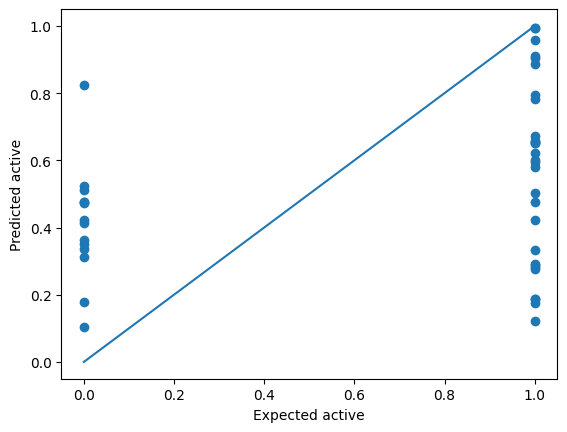

In [12]:
# Plot expected vs predicted values for the best model.
import matplotlib.pyplot as plt
plt.clf()
ax = plt.scatter(expected_best, predicted_best)
lims = [expected_best.min(), expected_best.max()]
plt.plot(lims, lims)  # Diagonal line.
plt.xlabel(f"Expected {config.data.response_column}");
plt.ylabel(f"Predicted {config.data.response_column}");

We can also calculate custom metrics for the best model:

In [14]:
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)
import numpy as np

# R2
r2 = r2_score(y_true=expected_best, y_pred=predicted_best)

# RMSE. sklearn 0.24 added squared=False to get RMSE, here we use np.sqrt().
rmse = np.sqrt(mean_squared_error(y_true=expected_best, y_pred=predicted_best))  

# MAE
mae = mean_absolute_error(y_true=expected_best, y_pred=predicted_best)

print(f"R2: {r2}, RMSE: {rmse}, Mean absolute error: {mae}")

R2: -0.08205485198350404, RMSE: 0.4874377939567763, Mean absolute error: 0.425779235282394


If the metrics look acceptable, the model is ready for use.

In [16]:
# FOR CLASSIFICATION
from sklearn.metrics import (roc_auc_score)
import numpy as np

roc_auc = roc_auc_score(y_true=expected_best, y_score=predicted_best)   
print(f"RMSE: {roc_auc}")

RMSE: 0.6724137931034483


### Build merged model

Now we can merge train and test data, and build (train) the model again. We will have no more holdout data to evaluate the model, but hopefully the model will be a little better by seeing a little more data.

In [143]:
# Build (Train) and save the model on the merged train+test data.
build_merged(buildconfig, "./merged.pkl")

In [18]:
import pickle
with open("./merged.pkl", "rb") as f:
    model_merged = pickle.load(f)
model_merged.predict_from_smiles(["NC1=NC=CC=C1C2=NC3=CC=C(C4=C(F)C(N5CC6(CN(C(C)=O)C6)C5)=CC=C4)N=C3N2C7=CC=C(C8(CCC8)N)C=C7", "CC(=O)Nc1ccc(O)cc1"])

array([0.87492206, 0.1888582 ])

In [19]:
import pandas as pd

df_merged = pd.read_csv(config.data.test_dataset_file)  # Load test data. (OR training_dataset_file, if you want to look)

expected_merged = df_merged[config.data.response_column]
predicted_merged = model_merged.predict_from_smiles(df_merged[config.data.input_column])
model_merged.predict_from_smiles(df_merged[config.data.input_column], explain=True) #explain

,shap_value,descriptor,bit,info
428,0.034575,ECFP_counts,428,c(C)(c)c
820,0.027801,ECFP_counts,820,c(nc)(C#N)nc
679,0.025874,ECFP_counts,679,C(c(n)n)#N
857,0.019745,ECFP_counts,857,c(-c)(c)c
1466,0.016660,ECFP_counts,1466,N(C(c)=O)C(C)c
...,...,...,...,...
1097,0.000000,ECFP_counts,1097,
1094,0.000000,ECFP_counts,1094,C1(C)(c(cc)nc)CC1
135,0.000000,ECFP_counts,135,c(n(C)n)c(-c)n
335,0.000000,ECFP_counts,335,c1c(C(N)=O)ccc(Cl)n1


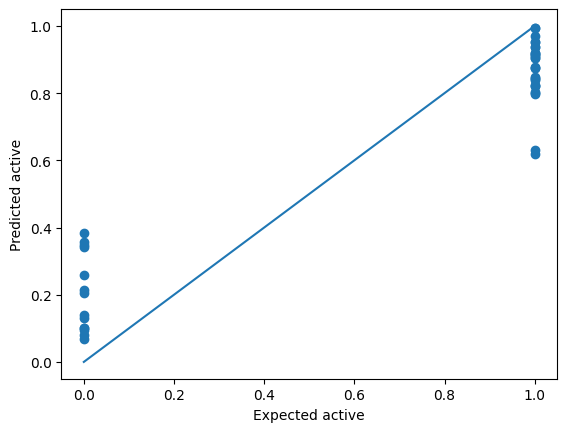

In [20]:
# Plot expected vs predicted values for the best model.
import matplotlib.pyplot as plt
plt.clf()
ax = plt.scatter(expected_merged, predicted_merged)
lims = [expected_merged.min(), expected_merged.max()]
plt.plot(lims, lims)  # Diagonal line.
plt.xlabel(f"Expected {config.data.response_column}");
plt.ylabel(f"Predicted {config.data.response_column}");

In [150]:
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error)
import numpy as np

# R2
r2 = r2_score(y_true=expected_merged, y_pred=predicted_merged)

# RMSE. sklearn 0.24 added squared=False to get RMSE, here we use np.sqrt().
rmse = np.sqrt(mean_squared_error(y_true=expected_merged, y_pred=predicted_merged))  

# MAE
mae = mean_absolute_error(y_true=expected_merged, y_pred=predicted_merged)

print(f"R2: {r2}, RMSE: {rmse}, Mean absolute error: {mae}")

R2: 0.8458643161013171, RMSE: 0.1839696398149506, Mean absolute error: 0.15328709529800594


In [21]:
# FOR CLASSIFICATION
from sklearn.metrics import (roc_auc_score)
import numpy as np

roc_auc = roc_auc_score(y_true=expected_merged, y_score=predicted_merged)   
print(f"RMSE: {roc_auc}")

RMSE: 1.0


### USE MODLE

In [45]:
import pickle
with open("./merged.pkl", "rb") as f:
    model = pickle.load(f)
model.predict_from_smiles(["CCC", "CC(=O)Nc1ccc(O)cc1"])

array([-21.80875556, -24.62125556])

In [48]:
df = pd.read_csv('summary.csv')  # Load data.

predicted = model.predict_from_smiles(df['smiles'])
print(predicted)

[-26.86351111 -21.60148889 -25.54291111 -24.88096667 -27.3784
 -22.21335556 -23.84867778 -35.21237778 -23.25791111 -27.83591111
 -24.65901111 -27.48867778 -26.39932222 -29.24852222 -24.55818889
 -24.27235556 -31.11732222 -27.09835556 -23.2933     -23.32342222
 -24.71471111 -29.70864444 -23.32742222 -22.91586667 -23.36328889
 -36.56367778 -17.61593333 -26.58677778 -26.83365556 -31.61725556
 -25.1502     -25.85488889 -14.63648889 -27.41512222 -28.94073333
 -23.08081111 -22.62647778 -21.22406667 -21.79095556 -38.04585556
 -35.44583333 -25.81492222 -20.97365556 -19.75926667 -31.51952222
 -28.27077778 -30.1027     -23.09251111 -26.06934444 -24.66792222
 -29.25865556 -20.43672222 -23.7695     -17.02826667 -23.63564444
 -20.55823333 -25.39624444 -29.07976556 -25.40682222 -28.50966389
 -28.27396389 -27.5525     -27.39188889 -28.773475   -28.71512667
 -26.38225278 -27.26205556 -26.45211111 -31.23296667 -25.06294444
 -24.67741111 -31.40245556 -29.07976556 -27.82798889 -25.868
 -29.15256667 -20.4

In [53]:
df['qsar'] = predicted

In [55]:
df.to_csv('summary.csv')